# **Image Sharpening Using Knowledge Distillation for Real-time Video Conferencing Enhancement**

## **1. Importing Project Dependencies & Setup**

In [1]:
# 📦 Core Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from tqdm import tqdm
import glob

# 🧠 PyTorch for Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.models import ResNet18_Weights

# 📊 Evaluation
from skimage.metrics import structural_similarity as ssim
import cv2

# 📸 Visualization
from IPython.display import display
import seaborn as sns

print("All Dependencies Imported Successfully...........")

All Dependencies Imported Successfully...........


In [2]:
# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## **2. Mounting The Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

print("Drive Mounted Successfully!.......")

Mounted at /content/drive
Drive Mounted Successfully!.......


## **3. Loading Image Data from Drive**

In [4]:
low_res_dir = "/content/drive/MyDrive/downgraded_images"
high_res_dir = "/content/drive/MyDrive/sharp_images"

image_size = (128, 128)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

def load_image_pairs(low_dir, high_dir):
    low_paths = sorted(glob.glob(os.path.join(low_dir, '*')))
    high_paths = sorted(glob.glob(os.path.join(high_dir, '*')))
    assert len(low_paths) == len(high_paths), "Mismatch in dataset sizes"

    low_res_images = []
    high_res_images = []

    for low_path, high_path in tqdm(zip(low_paths, high_paths), total=len(low_paths), desc="Loading images"):
        low_img = Image.open(low_path).convert('RGB')
        high_img = Image.open(high_path).convert('RGB')
        low_res_images.append(transform(low_img))
        high_res_images.append(transform(high_img))

    return torch.stack(low_res_images), torch.stack(high_res_images)

low_res_all, high_res_all = load_image_pairs(low_res_dir, high_res_dir)
print("Loaded:", low_res_all.shape, high_res_all.shape)

Loading images: 100%|██████████| 202/202 [01:16<00:00,  2.63it/s]

Loaded: torch.Size([202, 3, 128, 128]) torch.Size([202, 3, 128, 128])


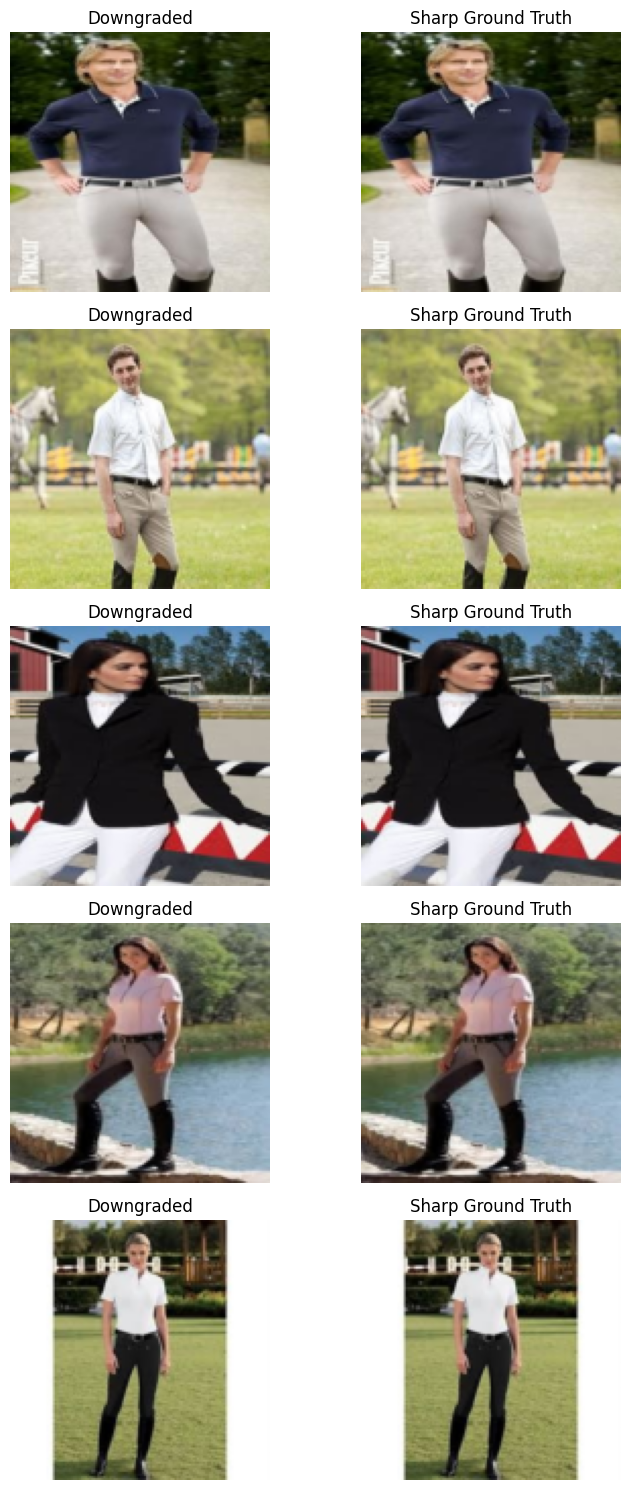

In [5]:
import matplotlib.pyplot as plt

# Function to display N samples from your loaded tensors
def show_loaded_samples(low_res_tensor, high_res_tensor, num_samples=5):
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 3 * num_samples))

    for i in range(num_samples):
        low_img = low_res_tensor[i].permute(1, 2, 0).numpy()
        high_img = high_res_tensor[i].permute(1, 2, 0).numpy()

        axes[i, 0].imshow(low_img)
        axes[i, 0].set_title("Downgraded")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(high_img)
        axes[i, 1].set_title("Sharp Ground Truth")
        axes[i, 1].axis("off")

    plt.tight_layout()
    plt.show()

# Run it!
show_loaded_samples(low_res_all, high_res_all, num_samples=5)


## **4. Defining Teacher and Student Models**

In [6]:
# ================================================
# 🔹 3. Define DnCNN Teacher and Student Models
# ================================================
# DnCNN implementation (simplified)
class DnCNN(nn.Module):
    def __init__(self, channels=3, num_of_layers=17):
        super(DnCNN, self).__init__()
        layers = []
        layers.append(nn.Conv2d(channels, 64, kernel_size=3, padding=1))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(num_of_layers - 2):
            layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(64, channels, kernel_size=3, padding=1))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        noise = self.dncnn(x)
        return x - noise  # Residual learning


class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x)


teacher = DnCNN().to(device).eval()
student = StudentNet().to(device)

## **5. Model Training on Knowledge Distillation**

In [7]:
# ================================================
# 🔹 4. Knowledge Distillation Training on Dataset
# ================================================
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(student.parameters(), lr=1e-3)

n_epochs = 8
losses = []

for epoch in range(n_epochs):
    total_loss = 0
    for i in tqdm(range(len(low_res_all))):
        input_tensor = low_res_all[i].unsqueeze(0).to(device)

        with torch.no_grad():
            teacher_output = teacher(input_tensor)

        student.train()
        output = student(input_tensor)
        loss = criterion(output, teacher_output)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(low_res_all)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{n_epochs}, Avg Loss: {avg_loss:.6f}")

100%|██████████| 202/202 [00:02<00:00, 82.45it/s] 


Epoch 1/8, Avg Loss: 0.017127


100%|██████████| 202/202 [00:01<00:00, 181.91it/s]


Epoch 2/8, Avg Loss: 0.003227


100%|██████████| 202/202 [00:01<00:00, 181.14it/s]


Epoch 3/8, Avg Loss: 0.002325


100%|██████████| 202/202 [00:01<00:00, 182.15it/s]


Epoch 4/8, Avg Loss: 0.001623


100%|██████████| 202/202 [00:01<00:00, 182.34it/s]


Epoch 5/8, Avg Loss: 0.001287


100%|██████████| 202/202 [00:01<00:00, 179.94it/s]


Epoch 6/8, Avg Loss: 0.001061


100%|██████████| 202/202 [00:01<00:00, 180.72it/s]


Epoch 7/8, Avg Loss: 0.000916


100%|██████████| 202/202 [00:01<00:00, 181.37it/s]

Epoch 8/8, Avg Loss: 0.000861


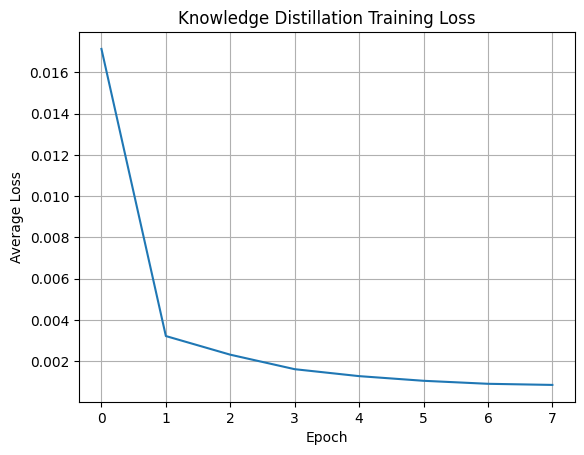

In [8]:
# Plot training loss
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Knowledge Distillation Training Loss")
plt.grid(True)
plt.show()

## **6. Model Evaluation And Visualization.**

In [9]:
# ================================================
# 🔹 5. Evaluation with SSIM and Visualization
# ================================================
student.eval()

idx = random.randint(0, len(low_res_all)-1)
input_tensor = low_res_all[idx].unsqueeze(0).to(device)
target_tensor = high_res_all[idx].permute(1, 2, 0).cpu().numpy()

with torch.no_grad():
    student_output = student(input_tensor).squeeze().permute(1, 2, 0).cpu().numpy()

ssim_score = ssim(
    (student_output * 255).astype(np.uint8),
    (target_tensor * 255).astype(np.uint8),
    channel_axis=-1
)
print(f"SSIM Score on Random Test Sample: {ssim_score:.4f}")

SSIM Score on Random Test Sample: 0.9724


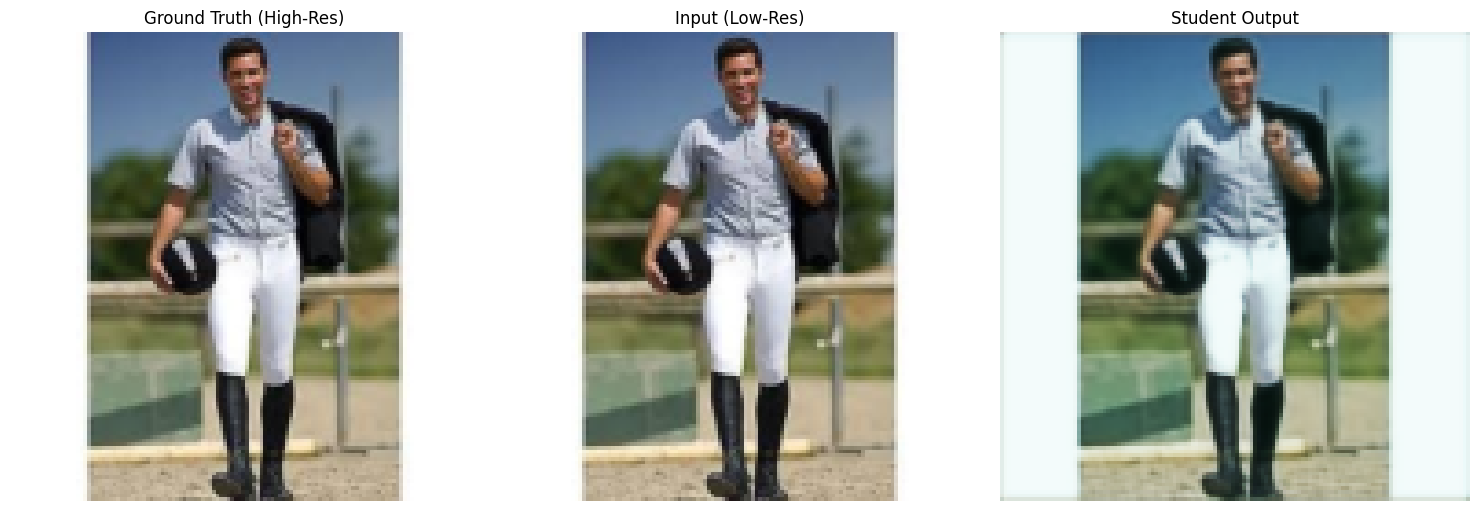

In [10]:
# Visual comparison
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(target_tensor)
axs[0].set_title("Ground Truth (High-Res)")
axs[1].imshow(low_res_all[idx].permute(1, 2, 0))
axs[1].set_title("Input (Low-Res)")
axs[2].imshow(student_output)
axs[2].set_title("Student Output")
for ax in axs: ax.axis("off")
plt.tight_layout()
plt.show()

In [11]:
# ================================================
# 🔹 6. Full Evaluation on the Dataset
# ================================================
from skimage.metrics import peak_signal_noise_ratio as psnr

student.eval()
teacher.eval()

total_ssim_student = 0.0
total_ssim_teacher = 0.0
total_psnr_student = 0.0
total_psnr_teacher = 0.0

num_samples = len(low_res_all)

for i in tqdm(range(num_samples), desc="Evaluating"):
    input_tensor = low_res_all[i].unsqueeze(0).to(device)
    target_tensor = high_res_all[i].permute(1, 2, 0).cpu().numpy()

    with torch.no_grad():
        student_output = student(input_tensor).squeeze().permute(1, 2, 0).cpu().numpy()
        teacher_output = teacher(input_tensor).squeeze().permute(1, 2, 0).cpu().numpy()

    student_img = (student_output * 255).astype(np.uint8)
    teacher_img = (teacher_output * 255).astype(np.uint8)
    target_img = (target_tensor * 255).astype(np.uint8)

    ssim_student = ssim(student_img, target_img, channel_axis=-1)
    ssim_teacher = ssim(teacher_img, target_img, channel_axis=-1)

    psnr_student = psnr(target_img, student_img, data_range=255)
    psnr_teacher = psnr(target_img, teacher_img, data_range=255)

    total_ssim_student += ssim_student
    total_ssim_teacher += ssim_teacher
    total_psnr_student += psnr_student
    total_psnr_teacher += psnr_teacher

avg_ssim_student = total_ssim_student / num_samples
avg_ssim_teacher = total_ssim_teacher / num_samples
avg_psnr_student = total_psnr_student / num_samples
avg_psnr_teacher = total_psnr_teacher / num_samples

print("\n🔍 Final Evaluation Results")
print(f"Student Avg SSIM:  {avg_ssim_student:.4f}")
print(f"Teacher Avg SSIM:  {avg_ssim_teacher:.4f}")
print(f"Student Avg PSNR:  {avg_psnr_student:.2f} dB")
print(f"Teacher Avg PSNR:  {avg_psnr_teacher:.2f} dB")


Evaluating: 100%|██████████| 202/202 [00:03<00:00, 66.09it/s]


🔍 Final Evaluation Results
Student Avg SSIM:  0.9519
Teacher Avg SSIM:  0.9132
Student Avg PSNR:  28.66 dB
Teacher Avg PSNR:  19.75 dB


In [12]:
import time

# Warm-up GPU (optional but helps avoid lazy CUDA init overhead)
input_tensor = low_res_all[0].unsqueeze(0).to(device)
for _ in range(5):
    _ = student(input_tensor)

# Time inference on multiple images
num_images = 100
start_time = time.time()

with torch.no_grad():
    for i in range(num_images):
        input_tensor = low_res_all[i].unsqueeze(0).to(device)
        _ = student(input_tensor)

end_time = time.time()
total_time = end_time - start_time
fps = num_images / total_time

print(f"\n⚡ Inference Speed: {fps:.2f} FPS over {num_images} images")



⚡ Inference Speed: 2063.05 FPS over 100 images


## **7. Model Saving & Loading**

In [13]:
# ================================================
# 🔹 Save Models
# ================================================

save_dir = "/content/drive/MyDrive/sharpening_models"
os.makedirs(save_dir, exist_ok=True)

student_path = os.path.join(save_dir, "student_model.pth")
teacher_path = os.path.join(save_dir, "teacher_model.pth")

torch.save(student.state_dict(), student_path)
torch.save(teacher.state_dict(), teacher_path)

print(f"✅ Models saved to: {save_dir}")


✅ Models saved to: /content/drive/MyDrive/sharpening_models


In [14]:
# ================================================
# 🔹 Load Models (for inference)
# ================================================

# Reinitialize model instances
loaded_student = StudentNet().to(device)
loaded_teacher = DnCNN().to(device)

# Load weights
loaded_student.load_state_dict(torch.load(student_path, map_location=device))
loaded_teacher.load_state_dict(torch.load(teacher_path, map_location=device))

# Set to eval mode
loaded_student.eval()
loaded_teacher.eval()

print("✅ Models loaded successfully.")

✅ Models loaded successfully.
